In [50]:
import pandas as pd

In [51]:
# 1. Load the risk mapping from the text file
risk_map = {}
with open(r"C:\Frank\UoT 2024-2025\MIE8888 Project\M13\risk_levels_RUIWU.txt", 'r') as f:
    for line in f:
        line = line.strip()
        # Skip headers and blank or separator lines
        if not line or line.startswith("procedure_code") or line.startswith("#####"):
            continue
        parts = line.split(',')
        if len(parts) == 2:
            code = parts[0].strip()
            try:
                risk = float(parts[1].strip())
            except ValueError:
                risk = 0.0
            risk_map[code] = risk

In [52]:
risk_map

{'11101': -3.0,
 '11107': -2.0,
 '11111': -1.0,
 '11112': -3.0,
 '11113': -2.0,
 '11114': -1.0,
 '11115': -3.0,
 '11116': -2.0,
 '12111': 0.0,
 '16511': -2.0,
 '16401': -1.0,
 '16202': -1.0,
 '16201': -1.0,
 '16102': 0.0,
 '16101': 0.0,
 '33141': 6.0,
 '33135': 6.0,
 '33134': 5.0,
 '33133': 6.0,
 '33131': 6.0,
 '33125': 6.0,
 '33124': 6.0,
 '33122': 5.0,
 '33121': 4.0,
 '33115': 6.0,
 '33114': 6.0,
 '33113': 5.0,
 '33112': 6.0,
 '33111': 4.0,
 '33105': 6.0,
 '33104': 6.0,
 '33102': 6.0,
 '33101': 4.0}

In [53]:
# 2. Load the full patient data from CSV
# df = pd.read_csv(r"C:\Frank\UoT 2024-2025\MIE8888 Project\Data\Complete Data\21_treatements_backup_joined_patients_procedure_na_removed.csv")
df = pd.read_csv(r"C:\Frank\UoT 2024-2025\MIE8888 Project\Data\Complete Data\Mytestdataset.csv")
df['procedure_year'] = pd.to_datetime(df['procedure_date']).dt.year
df['age_at_filling'] = df['procedure_year'] - pd.to_datetime(df['birth_date']).dt.year

In [55]:
# 3. Map each treatment's procedure code to its risk value.
df['risk'] = df['procedure_code_y'].astype(str).map(risk_map)
# fill missing risk values with 0 (if any procedure code is not found in risk_map).
df['risk'] = df['risk'].fillna(0)

In [ ]:
df.head()

,patient_id,birth_date,first_visit,last_visit,procedure_code_x,procedure_date,procedure_year,age_at_filling,risk
0,1,1955-06-10 00:00:00+00:00,1991-04-30T00:00:00,2013-04-30T00:00:00,449,2004-04-19 00:00:00+00:00,2004,49.0,0.0
1,1,1955-06-10 00:00:00+00:00,1991-04-30T00:00:00,2013-04-30T00:00:00,713,2004-04-19 00:00:00+00:00,2004,49.0,0.0
2,1,1955-06-10 00:00:00+00:00,1991-04-30T00:00:00,2013-04-30T00:00:00,786,2004-04-19 00:00:00+00:00,2004,49.0,0.0
3,1,1955-06-10 00:00:00+00:00,1991-04-30T00:00:00,2013-04-30T00:00:00,1357,2004-04-19 00:00:00+00:00,2004,49.0,0.0
4,1,1955-06-10 00:00:00+00:00,1991-04-30T00:00:00,2013-04-30T00:00:00,5212,2007-07-11 00:00:00+00:00,2007,52.0,0.0


In [57]:
# Get a txt doc of procedure_code with 0 risk level
zero_risk_procedure_codes = []
for i, r in enumerate(df['risk']):
    if r == 0:
        zero_risk_procedure_codes.append(df['procedure_code_y'][i])

with open("zero_risk_procedure_codes.txt", "w") as file:
    for code in zero_risk_procedure_codes:
        file.write(str(code) + "\n")

In [58]:
# Get a txt doc of procedure_code with 0 risk level
non_zero_risk_procedure_codes = []
for i, r in enumerate(df['risk']):
    if r != 0:
        non_zero_risk_procedure_codes.append(df['procedure_code_y'][i])

with open("non_zero_risk_procedure_codes.txt", "w") as file:
    for code in non_zero_risk_procedure_codes:
        file.write(str(code) + "\n")

In [59]:
# 4. Define a function to compute the final normalized risk for a single patient.
def compute_patient_risk(patient_df):
    # Determine the treatment timeline for the patient
    min_year = patient_df['procedure_year'].min()
    max_year = patient_df['procedure_year'].max()
    normalized_risks = []
    
    # Slide the window year by year from the first to the last treatment year.
    for current_year in range(min_year, max_year + 1):
        start_window = current_year - 5
        end_window = current_year + 2
        # Filter treatments that fall within the current window.
        window_df = patient_df[(patient_df['procedure_year'] >= start_window) & (patient_df['procedure_year'] <= end_window)]
        risk_sum = window_df['risk'].sum()
        # Normalize the risk sum to the 6-point scale.
        normalized_risk = risk_sum / 6
        normalized_risks.append(normalized_risk)
    
    # The final risk is the average of normalized risks from each window.
    if normalized_risks:
        final_risk = sum(normalized_risks) / len(normalized_risks)
    else:
        final_risk = 0
    return final_risk

In [60]:
patient_risks = df.groupby('patient_id').apply(compute_patient_risk)
patient_risk_df = patient_risks.reset_index()
patient_risk_df.columns = ['patient_id', 'final_risk']
print(patient_risk_df.head())

   patient_id  final_risk
0           1   -2.422222
1           2   -4.916667
2           3   -3.648148
3           4   -3.493827
4           5   -2.121212


C:\Users\frank\AppData\Local\Temp\ipykernel_44432\413853556.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_risks = df.groupby('patient_id').apply(compute_patient_risk)


In [61]:
patient_risk_df

,patient_id,final_risk
0,1,-2.422222
1,2,-4.916667
2,3,-3.648148
3,4,-3.493827
4,5,-2.121212
...,...,...
10851,13580,-1.694444
10852,13583,0.000000
10853,13584,-1.000000
10854,13586,-0.425926


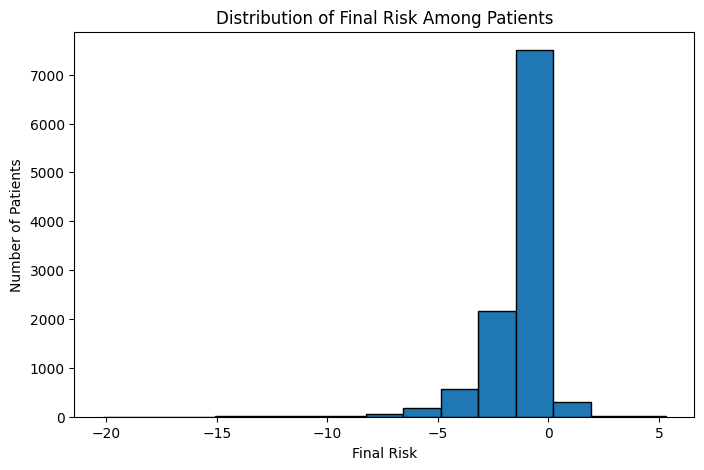

In [76]:
import matplotlib.pyplot as plt

# Plot a histogram of final risk
plt.figure(figsize=(8, 5))
plt.hist(patient_risk_df['final_risk'], bins=15, edgecolor='black')
plt.xlabel('Final Risk')
plt.ylabel('Number of Patients')
plt.title('Distribution of Final Risk Among Patients')
plt.show()

In [ ]:
# High_risk_patient_id = []
# for i, r in enumerate(patient_risk_df['final_risk']):
#     if r >= 4:
#         High_risk_patient_id.append(patient_risk_df['patient_id'][i])
# # with open("High_risk_patient_id.txt", "w") as file:
# #     for code in High_risk_patient_id:
# #         file.write(str(code) + "\n")

# Medium_risk_patient_id = []
# for i, r in enumerate(patient_risk_df['final_risk']):
#     if r <= 4 and r > 1:
#         Medium_risk_patient_id.append(patient_risk_df['patient_id'][i])
# # with open("Medium_risk_patient_id.txt", "w") as file:
# #     for code in Medium_risk_patient_id:
# #         file.write(str(code) + "\n")

# Low_risk_patient_id = []
# for i, r in enumerate(patient_risk_df['final_risk']):
#     if r <= 1:
#         Low_risk_patient_id.append(patient_risk_df['patient_id'][i])
# # with open("Low_risk_patient_id.txt", "w") as file:
# #     for code in Low_risk_patient_id:
# #         file.write(str(code) + "\n")

C:\Users\frank\AppData\Local\Temp\ipykernel_44432\3947847094.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=patient_risk_df, x='risk_category',


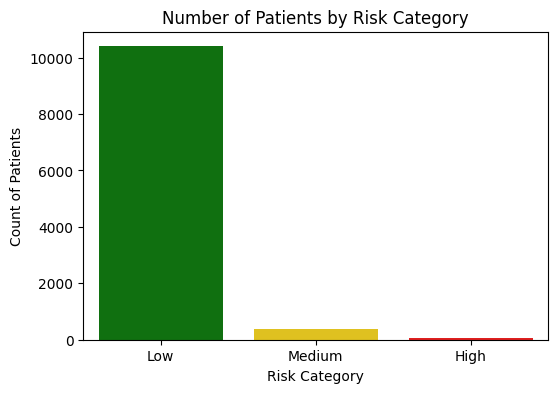

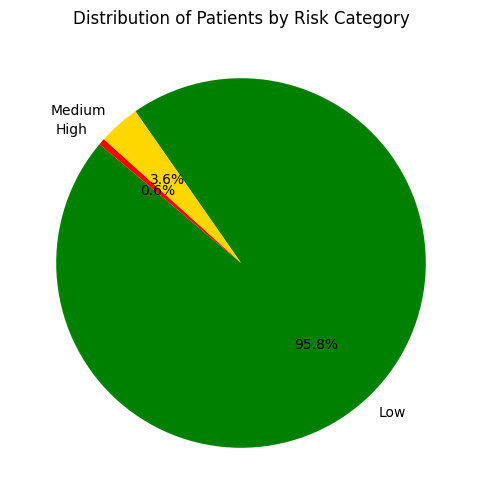

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def categorize_risk(r):
    if r > 1:
        return 'High'
    elif r > 0:
        return 'Medium'
    else:
        return 'Low'

patient_risk_df['risk_category'] = patient_risk_df['final_risk'].apply(categorize_risk)

# -------------------------------------
# Bar Chart of Risk Categories
# -------------------------------------
plt.figure(figsize=(6, 4))
sns.countplot(data=patient_risk_df, x='risk_category', 
              order=['Low', 'Medium', 'High'], 
              palette=['green','gold','red'])
plt.title('Number of Patients by Risk Category')
plt.xlabel('Risk Category')
plt.ylabel('Count of Patients')
plt.show()

# -------------------------------------
# Pie Chart of Risk Categories
# -------------------------------------
risk_counts = patient_risk_df['risk_category'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(risk_counts, 
        labels=risk_counts.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=['green','gold','red'])
plt.title('Distribution of Patients by Risk Category')
plt.show()